In [30]:
import pandas as pd

data_path = '/kaggle/input/bike-sharing-demand/'

train_set = pd.read_csv(data_path + 'train.csv')
test_set = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [31]:
# remove outlier
train_set = train_set[train_set['weather']!=4]

In [32]:
temp_all_data = pd.concat([train_set, test_set], ignore_index=True)
temp_all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [33]:
from datetime import datetime

temp_all_data['date'] = temp_all_data['datetime'].apply(lambda x:x.split()[0])

temp_all_data['year'] = temp_all_data['datetime'].apply(lambda x:x.split()[0].split('-')[0])
temp_all_data['month'] = temp_all_data['datetime'].apply(lambda x:x.split()[0].split('-')[1])
temp_all_data['hour'] = temp_all_data['datetime'].apply(lambda x:x.split()[1].split(':')[0])
temp_all_data['weekday'] = temp_all_data['date'].apply(lambda dateString:datetime.strptime(dateString, '%Y-%m-%d').weekday())

temp_all_data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,01,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,01,01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,01,02,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,01,03,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,01,04,5


In [34]:
drop_featrue = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']
temp_all_data = temp_all_data.drop(drop_featrue, axis=1)

In [35]:
X_train = temp_all_data[~pd.isnull(temp_all_data['count'])]
X_test = temp_all_data[pd.isnull(temp_all_data['count'])]

X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train_set['count']

In [36]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


In [37]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output    

In [38]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

log_y = np.log(y)
linear_reg_model.fit(X_train, log_y)

LinearRegression()

In [39]:
preds = linear_reg_model.predict(X_train)
print(f'선형 회귀 모델 RMSLE: {rmsle(log_y, preds, True):.4f}' )

선형 회귀 모델 RMSLE: 1.0205


In [40]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

In [41]:
ridge_params = {'max_iter': [3000], 'alpha': [0.1, 1,2,3,4,10,30,100,200,300,400,800,900,1000]}

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

gridsearch_ridge_model = GridSearchCV(estimator=ridge_model, 
                                      param_grid=ridge_params, 
                                      scoring=rmsle_scorer,
                                      cv=5)


In [42]:
log_y = np.log(y)
gridsearch_ridge_model.fit(X_train, log_y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [43]:
print(gridsearch_ridge_model.best_params_)

{'alpha': 0.1, 'max_iter': 3000}


In [44]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

print(f'{rmsle(log_y, preds, True):.4f}')

1.0205


In [48]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800 , 900, 1000])
lasso_params = {'max_iter': [300], 'alpha': lasso_alpha}

gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

preds = gridsearch_lasso_model.best_estimator_.predict(X_train)
print(f'{rmsle(log_y, preds, True):.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e+01, tolerance: 1.944e+00
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.026e+01, tolerance: 1.944e+00
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.550e+02, tolerance: 1.944e

1.0205


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.666e+02, tolerance: 1.944e+00
  model = cd_fast.enet_coordinate_descent(


In [52]:
from sklearn.ensemble import RandomForestRegressor

randomforest_model = RandomForestRegressor()

rf_params = {'random_state': [42], 'n_estimators':[100,120,140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)

log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)
print(f'{rmsle(log_y, preds, True):.4f}')

0.1127


<Axes: ylabel='Count'>

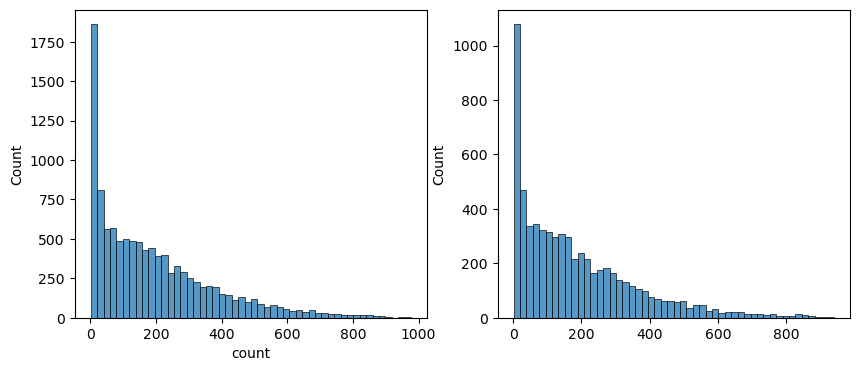

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
 
randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])

In [ ]:
submission['count'] = np.exp(randomforest_preds)
submission.to_csv('submission.csv', index=False)